In [4]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import pickle
import matplotlib.pyplot as plt
#from skimage import data
from skimage import filters
from skimage import exposure
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rc('font', family='serif')

In [5]:
data = pickle.load(open('XXX-SRB2.p', 'rb'))
ACCEPTED_PROB = 0.80

In [6]:
keys = list(data.keys())

In [7]:
labels = []
for key in keys:
    lab = key.split('.')
    lab[-2] += '_mask'
    lab = '.'.join(lab)
    labels.append(lab)

In [8]:
assert len(labels)==len(keys)

In [9]:
preds = []
for key in keys:
    pred = data.get(key)[...,1]
    pred = np.where(pred>ACCEPTED_PROB, 1, 0)
    preds.append(pred)

In [10]:
def get_label_stats(mask):
#    if mask.max() > 1:
#        mask = mask/255.

    label_im, nb_labels = ndimage.label(mask)
    sizes_each = ndimage.sum(mask, label_im, range(nb_labels + 1) )
    sizes_sum  = sizes_each.sum()

    return nb_labels, sizes_each, sizes_sum

In [11]:
true_count, _, true_area = get_label_stats(plt.imread(labels[0]))
pred_count, _, pred_area = get_label_stats(preds[-1])

In [12]:
camera = plt.imread(keys[0])[...,0]
val = filters.threshold_otsu(camera)
otsu_count, _, otsu_area = get_label_stats(camera > val)

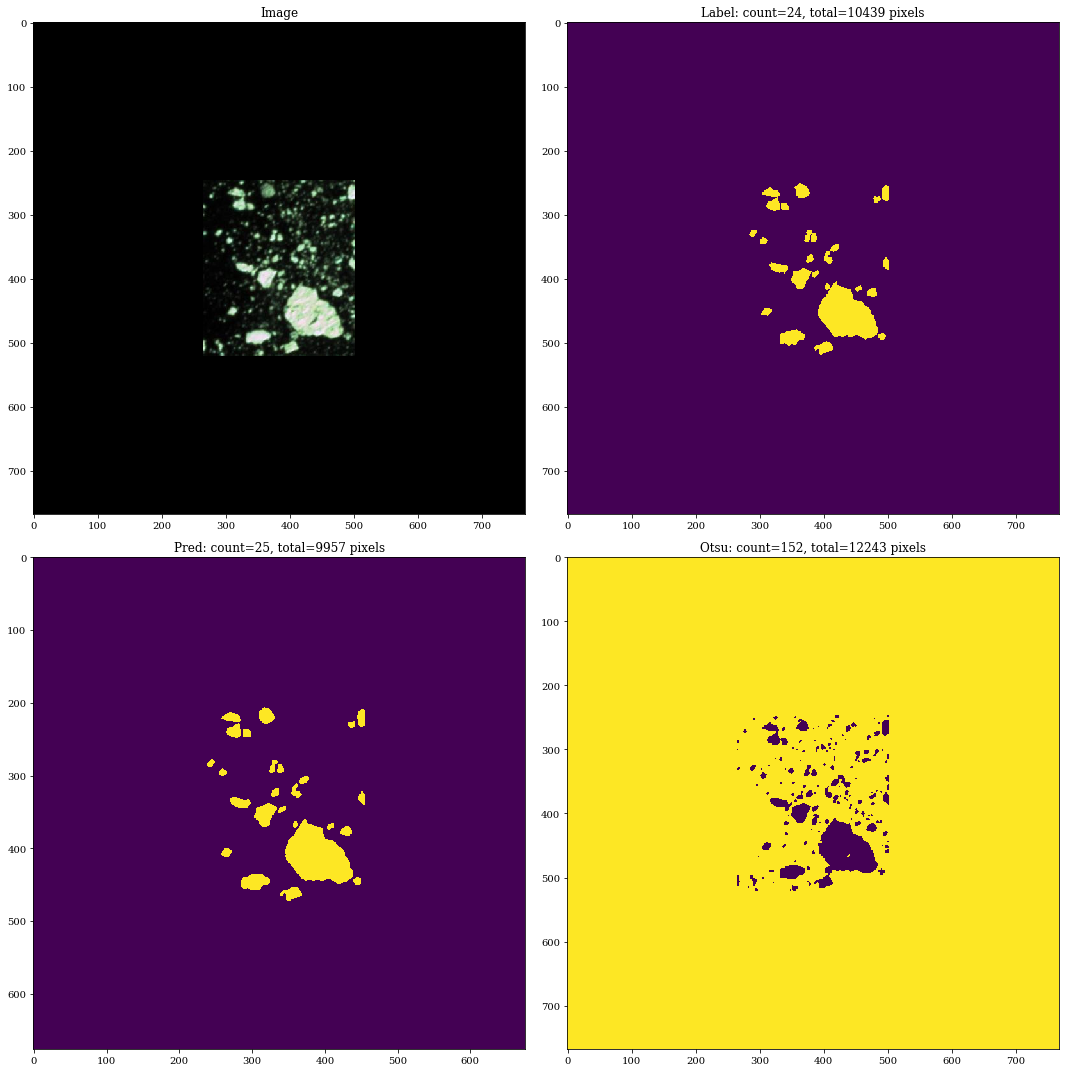

In [13]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221)
ax.imshow(plt.imread(keys[0]) )
ax.title.set_text("Image")

ax = fig.add_subplot(222)
ax.imshow(plt.imread(labels[0]))
ax.title.set_text("Label: count={}, total={} pixels".format(true_count, int(true_area)))

ax = fig.add_subplot(223)
ax.imshow(preds[-1])
ax.title.set_text("Pred: count={}, total={} pixels".format(pred_count, int(pred_area)))

ax = fig.add_subplot(224)
ax.imshow(camera < val)
ax.title.set_text("Otsu: count={}, total={} pixels".format(otsu_count, int(otsu_area)))
#plt.show()
plt.tight_layout()
plt.savefig("fq-size-N.png", dpi=300)

In [14]:
all_counts_true = []
all_counts_pred = []
all_counts_otsu = []

all_area_true = []
all_area_pred = []
all_area_otsu = []
for i in range(len(preds)):
    image_grey = plt.imread(keys[i])[...,0]
    val = filters.threshold_otsu(image_grey)
    
    otsu_count, _, otsu_area = get_label_stats(image_grey > val)
    true_count, _, true_area = get_label_stats(plt.imread(labels[i]))
    pred_count, _, pred_area = get_label_stats(preds[i-1])
    
    all_counts_true.append(true_count)
    all_counts_pred.append(pred_count)
    all_counts_otsu.append(otsu_count)

    all_area_true.append(true_area*9/1e6)
    all_area_pred.append(pred_area*9/1e6)
    all_area_otsu.append(otsu_area*9/1e6)
    
delta_area_pred = [9/1e6*(x-y) for x,y in zip(all_area_true, all_area_pred)]
delta_area_otsu = [9/1e6*(x-y) for x,y in zip(all_area_true, all_area_otsu)]

# create plots

In [15]:
plt.clf()

fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(121)
ax.scatter(all_area_true, all_area_pred, c='g', s=200,edgecolors='w', alpha=0.8)
xlim1 = max(np.asarray(all_area_pred).max(), np.asarray(all_area_true).max())
diag = [0,xlim1]
ax.plot(diag,diag,c='grey',ls='--', lw=1.5)
ax.set_aspect("equal")
ax.grid(linestyle='dotted')
ax.set_xlabel(r'True iceberg net area (km$^2$)')
ax.set_ylabel(r"UNet iceberg net area (km$^2$)")
ax.set_xlim([0,xlim1])
ax.set_ylim([0,xlim1])
ax.title.set_text('Area: True vs. UNet')

ax = fig.add_subplot(122)
ax.scatter(all_area_true, all_area_otsu, c='r', s=200,edgecolors='w', alpha=0.8)
xlim1 = max(np.asarray(all_area_otsu).max(), np.asarray(all_area_true).max())
diag = [0,xlim1]
ax.plot(diag,diag,c='grey',ls='--', lw=1.5)
ax.title.set_text('Area: True vs. Otsu')
ax.set_aspect("equal")
ax.set_xlabel(r'True iceberg net area (km$^2$)')
ax.set_ylabel(r"Otsu iceberg net area (km$^2$)")
ax.set_xlim([0,xlim1])
ax.set_ylim([0,xlim1])
ax.grid(linestyle='dotted')

<Figure size 432x288 with 0 Axes>

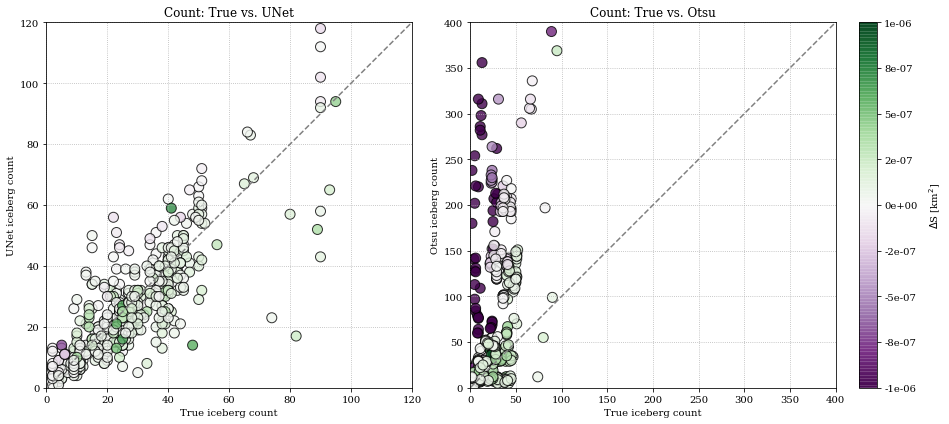

In [16]:
fig = plt.figure(figsize=(14, 6))
#plt.suptitle('comparisons', fontsize=15, fontweight='bold')

cm = plt.cm.get_cmap('PRGn')

scatter_args = {'c':delta_area_pred, 's':100, 'alpha':0.8, 'cmap':cm, 'edgecolor':'k', 'vmin':-1e-6, 'vmax':1e-6}

plt.subplot(121)
plt.scatter(all_counts_true, all_counts_pred, **scatter_args)
plt.plot([0,200], [0,200], c='grey', ls='--', lw=1.5)
plt.gca().set_aspect("equal")
plt.grid(linestyle='dotted')
plt.xlabel('True iceberg count')
plt.ylabel("UNet iceberg count")
plt.xlim([0,120])
plt.ylim([0,120])
plt.title('Count: True vs. UNet')

scatter_args['c'] = delta_area_otsu

plt.subplot(122)
plt.scatter(all_counts_true, all_counts_otsu, **scatter_args)
plt.plot([0,500], [0,500],c='grey', ls='--', lw=1.5)
plt.title('Count: True vs. Otsu')
plt.gca().set_aspect("equal")
plt.xlabel('True iceberg count')
plt.ylabel("Otsu iceberg count")
plt.xlim([0,400])
plt.ylim([0,400])
plt.grid(linestyle='dotted')
cbar = plt.colorbar(format='%.0e')
cbar.set_label("$\Delta$S [km$^2$]", labelpad=+10)
plt.tight_layout()

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('comparisons-count-area-ALL.png',dpi=300)

In [18]:
delta_counts_pred = [x-y for x,y in zip(all_counts_true, all_counts_pred)]
delta_counts_otsu = [x-y for x,y in zip(all_counts_true, all_counts_otsu)]

fig = plt.figure(figsize=(14, 6))
#plt.suptitle('comparisons', fontsize=15, fontweight='bold')

cm = plt.cm.get_cmap('RdGy')

scatter_args = {'c':delta_counts_pred, 's':100, 'alpha':0.8, 'cmap':cm, 'edgecolor':'k', 'vmin':-40, 'vmax':40}

plt.subplot(121)
plt.scatter(all_area_true, all_area_pred, **scatter_args)
xlim1 = 0.2#max(np.asarray(all_area_pred).max(), np.asarray(all_area_true).max())
diag = [0,xlim1]
plt.plot(diag, diag, c='grey', ls='--', lw=1.5)
plt.gca().set_aspect("equal")
plt.grid(linestyle='dotted')
plt.xlabel(r'True iceberg net area (km$^2$)')
plt.ylabel(r"UNet iceberg net area (km$^2$)")
plt.xlim(diag)
plt.ylim(diag)
plt.title('Area: True vs. UNet')

scatter_args['c'] = delta_counts_otsu

plt.subplot(122)
plt.scatter(all_area_true, all_area_otsu, **scatter_args)
xlim1 = 0.2#max(np.asarray(all_area_pred).max(), np.asarray(all_area_true).max())
diag = [0,xlim1]
plt.plot(diag, diag,c='grey', ls='--', lw=1.5)
plt.title('Area: True vs. Otsu')
plt.gca().set_aspect("equal")
plt.xlabel(r'True iceberg net area (km$^2$)')
plt.ylabel(r"Otsu iceberg net area (km$^2$)")
plt.xlim(diag)
plt.ylim(diag)
plt.grid(linestyle='dotted')
cbar = plt.colorbar(extend='both')
cbar.set_label(r"$\Delta$Count $(n-m)$", labelpad=+10)
plt.tight_layout()

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('comparisons-area-count-ALL-zoom.png',dpi=300)

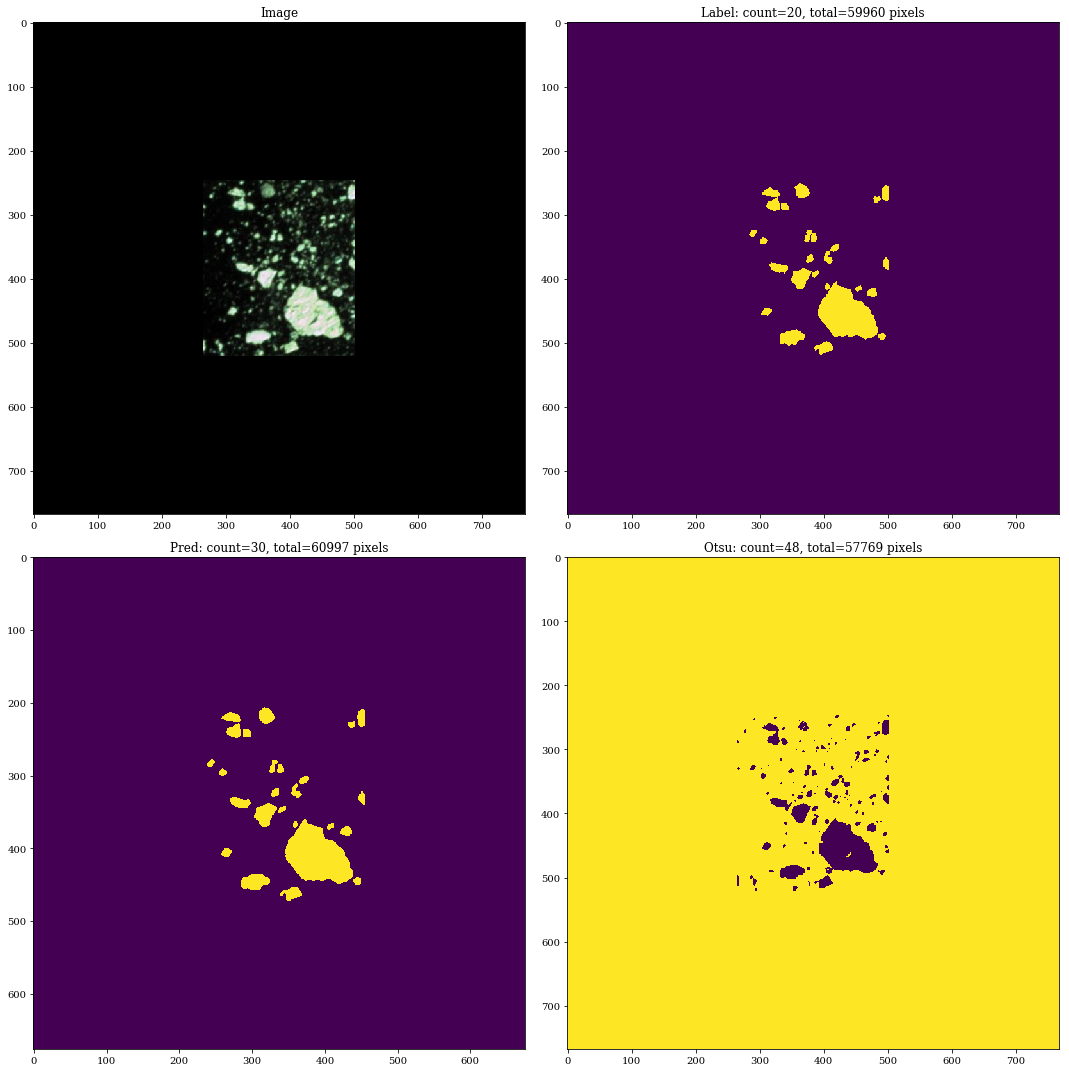

In [19]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221)
ax.imshow(plt.imread(keys[0]) )
ax.title.set_text("Image")

ax = fig.add_subplot(222)
ax.imshow(plt.imread(labels[0]))
ax.title.set_text("Label: count={}, total={} pixels".format(true_count, int(true_area)))

ax = fig.add_subplot(223)
ax.imshow(preds[-1])
ax.title.set_text("Pred: count={}, total={} pixels".format(pred_count, int(pred_area)))

ax = fig.add_subplot(224)
ax.imshow(camera < val)
ax.title.set_text("Otsu: count={}, total={} pixels".format(otsu_count, int(otsu_area)))
#plt.show()
plt.tight_layout()
#plt.savefig("fq-size-N.png", dpi=300)

In [20]:
_image = plt.imread(keys[0])
_pred  = preds[-1]
_otsu  = camera

In [22]:
print("shape of the image: {}".format(_image[...,0].shape))
print("shape of the prediction: {}".format(_pred.shape))
print("shape of the Ptsu: {}".format(_otsu.shape))

shape of the image: (768, 768)
shape of the prediction: (676, 676)
shape of the Ptsu: (768, 768)


In [25]:
print("shape of the prediction: {}".format(_pred[int((676-512)/2):int((676-512)/2)+512,int((676-512)/2):int((676-512)/2)+512].shape))

shape of the prediction: (512, 512)


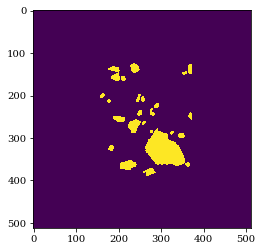

In [26]:
heart = _pred[int((676-512)/2):int((676-512)/2)+512,int((676-512)/2):int((676-512)/2)+512]
plt.imshow(heart)